# Introduction

[Kaggle Competition - Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)

### Goal
 This project involves a binary classification problem: determining whether a small image patch, extracted from larger histopathologic scans, contains evidence of metastatic cancer.

### Dataset Overview
 The dataset provided consists of high-resolution TIFF images in RGB format, each paired with a binary label indicating the presence (1) or absence (0) of cancer cells. Each image maintains consistent dimensions, which simplifies preprocessing while preserving the intricate details necessary for accurate detection.

### EDA

I perform exploratory data analysis (EDA) to understand the data distribution, validate the quality of the images, and establish a robust preprocessing pipeline. Finally, the trained models are evaluated using ROC AUC metrics, and predictions are generated for submission to the Kaggle leaderboard.

### Approach
2 deep learning approaches:

1) A baseline model utilizing SeparableConv2D layers, designed to efficiently extract image features while minimizing computational cost.

2) An alternative model incorporating standard Conv2D layers with residual connections, which aim to improve feature learning by allowing the network to bypass certain layers and mitigate issues like vanishing gradients.

### Hyperparameter Tuning

I use Keras Tuner’s RandomSearch to optimize various parameters such as the number of filters in convolutional layers, the size of the dense layer, dropout rates, and the learning rate. This thorough approach not only aims to maximize model performance but also provides valuable insights into the impact of different architectural choices on the detection task.

In [1]:
run_get_data = True # Upload the kaggle.json and make True if this hasn't been done once.

if run_get_data:
  !pip install -q kaggle
  !pip install -q keras-tuner

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle competitions download -c histopathologic-cancer-detection

  !unzip -q histopathologic-cancer-detection.zip -d /content/data
  !echo "Unzip complete"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.3 MB/s eta 0:00:00
100% 6.31G/6.31G [05:04<00:00, 24.7MB/s]
100% 6.31G/6.31G [05:04<00:00, 22.2MB/s]
Unzip complete


In [2]:
import os
import sys
import random
import shutil
import subprocess
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


from PIL import Image, UnidentifiedImageError

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import mixed_precision, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Add, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


mixed_precision.set_global_policy('mixed_float16') # Enable mixed precision training for faster performance on supported GPUs

import keras_tuner as kt


class CancerDetectionModel:
    def __init__(self, data_dir='/content/data', input_shape=(64, 64, 3), file_ext='.tif'):
        self.data_dir = data_dir
        self.train_folder = os.path.join(data_dir, 'train')
        self.train_norm_folder = os.path.join(data_dir, 'train_normalized')
        self.labels_path = os.path.join(data_dir, 'train_labels.csv')
        os.makedirs(self.train_norm_folder, exist_ok=True)

        self.input_shape = input_shape
        self.model = None
        self.history = None

        self.labels_df = None
        self.train_df = None
        self.val_df = None

        # File extension to use when creating filenames from ids
        self.file_ext = file_ext

    #TODO - REPLACE FIRST CELL
    # def setup_kaggle(self):
    #     try:
    #         # Install Kaggle and setup credentials
    #         subprocess.run(["pip", "install", "-q", "kaggle"], check=True)
    #         os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    #         shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    #         os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    #         # Download and unzip dataset
    #         subprocess.run(["kaggle", "competitions", "download", "-c", "histopathologic-cancer-detection"], check=True)
    #         subprocess.run(["unzip", "-q", "histopathologic-cancer-detection.zip", "-d", self.data_dir], check=True)
    #         print("Kaggle setup and data download/unzip complete")
    #     except Exception as e:
    #         print("Error during Kaggle setup:", e)

    def load_data(self, test_size=0.2, random_state=1337, train_fraction=1.0):
        self.labels_df = pd.read_csv(self.labels_path)

        self.labels_df['filename'] = self.labels_df['id'].astype(str) + self.file_ext

        # Filter out rows where the image file does not exist
        self.labels_df['exists'] = self.labels_df['filename'].apply(
            lambda x: os.path.exists(os.path.join(self.train_folder, x))
        )
        missing_count = (~self.labels_df['exists']).sum()
        if missing_count > 0:
            print(f"Warning: {missing_count} files listed in CSV were not found in {self.train_folder}")
        self.labels_df = self.labels_df[self.labels_df['exists']].copy()
        self.labels_df.drop(columns=['exists'], inplace=True)

        # Split the DataFrame into training and validation sets
        self.train_df, self.val_df = train_test_split(
            self.labels_df, test_size=test_size, random_state=random_state, stratify=self.labels_df['label']
        )

        # Sample the training data if train_fraction is less than 1.0
        if train_fraction < 1.0:
            self.train_df = self.train_df.sample(frac=train_fraction, random_state=random_state)
            print(f"Using {len(self.train_df)} training samples ({train_fraction*100}%)")

        # Ensure label values are strings
        self.train_df['label'] = self.train_df['label'].astype(str)
        self.val_df['label'] = self.val_df['label'].astype(str)

        print(f"Training samples: {len(self.train_df)}, Validation samples: {len(self.val_df)}")
        print("Sample training data:\n", self.train_df.head())

    def sample_image_detailed(self):
        tif_files = [f for f in os.listdir(self.train_folder) if f.lower().endswith(('.tif', '.tiff'))]
        if not tif_files:
            print("No TIFF files found in the training folder.")
            return

        sample_file = random.choice(tif_files)
        sample_path = os.path.join(self.train_folder, sample_file)
        try:
            sample_image = Image.open(sample_path)
            print(f"\nSample Image: {sample_file}")
            print(f" - Format: {sample_image.format}")
            print(f" - Size (width, height): {sample_image.size}")
            print(f" - Mode: {sample_image.mode}")

            # EDGE DETECTION
            img_array = np.array(sample_image.convert("L"))
            edges = cv2.Canny(img_array, threshold1=100, threshold2=200)
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(sample_image)
            plt.title("Original")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(edges, cmap='gray')
            plt.title("Edge Detection")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        except UnidentifiedImageError:
            print(f"Could not open image: {sample_file}")


    def plot_label_distribution(self):
        df = model_obj.labels_df
        counts = df['label'].value_counts()
        plt.figure(figsize=(6,4))
        counts.plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Label Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_pixel_histograms(self, bins=50, sample_num = 50):
        sample_images = [os.path.join(model_obj.train_folder, f) for f in os.listdir(model_obj.train_folder) if f.lower().endswith('.tif')][:sample_num]

        red_vals, green_vals, blue_vals = [], [], []

        for path in sample_images:
            try:
                img = Image.open(path).convert('RGB')
                img_array = np.array(img)
                red_vals.extend(img_array[:,:,0].flatten())
                green_vals.extend(img_array[:,:,1].flatten())
                blue_vals.extend(img_array[:,:,2].flatten())
            except Exception as e:
                print(f"Error loading image {path}: {e}")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.hist(red_vals, bins=bins, color='red', alpha=0.7)
        plt.title('Red Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

        plt.subplot(1, 3, 2)
        plt.hist(green_vals, bins=bins, color='green', alpha=0.7)
        plt.title('Green Channel Distribution')
        plt.xlabel('Pixel Intensity')

        plt.subplot(1, 3, 3)
        plt.hist(blue_vals, bins=bins, color='blue', alpha=0.7)
        plt.title('Blue Channel Distribution')
        plt.xlabel('Pixel Intensity')

        plt.tight_layout()
        plt.show()

    def channel_mean_std(self, sample_size=1000):
        tif_files = [f for f in os.listdir(self.train_folder) if f.lower().endswith(('.tif', '.tiff'))]
        sample_files = random.sample(tif_files, min(sample_size, len(tif_files)))
        means, stds = [], []

        for f in tqdm(sample_files, desc="Computing channel mean/std", unit="file"):
            try:
                img_path = os.path.join(self.train_folder, f)
                img = Image.open(img_path).convert("RGB")
                img_array = np.array(img, dtype=np.float32) / 255.0
                means.append(img_array.mean(axis=(0, 1)))
                stds.append(img_array.std(axis=(0, 1)))
            except Exception:
                continue

        channel_mean = np.mean(means, axis=0)
        channel_std = np.mean(stds, axis=0)
        print("Channel Means:", channel_mean)
        print("Channel Stds:", channel_std)
        # return channel_mean, channel_std

    def build_model(self):
        self.model = Sequential([
            SeparableConv2D(32, (3, 3), activation='relu', padding='same', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),

            SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),

            SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),

            GlobalAveragePooling2D(),

            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.summary()

    def build_model_alternative(self):
        inputs = Input(shape=self.input_shape)

        # First Convolutional Block
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)

        # Residual Block
        # Save the input to the block for the residual connection
        shortcut = x
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        # Adjust the shortcut to match the dimensions if necessary
        shortcut = Conv2D(64, (1, 1), padding='same')(shortcut)
        # Add the residual connection
        x = Add()([x, shortcut])
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)

        # Third Convolutional Block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)

        # Classification Block
        x = GlobalAveragePooling2D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.summary()

        self.model = model


    def train_model(self, epochs=5, batch_size=32):
        # Data augmentation for training and rescaling for validation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        # Create generators using the DataFrame splits and the 'filename' column
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=self.train_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=self.val_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator
        )

    def tune_model(self, epochs=5, batch_size=32, max_trials=10, executions_per_trial=1):
        def build_model_hp(hp):
            model = Sequential()
            model.add(SeparableConv2D(
                hp.Int("filters_1", min_value=16, max_value=64, step=16),
                (3, 3),
                activation='relu',
                padding='same',
                input_shape=self.input_shape
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())

            model.add(SeparableConv2D(
                hp.Int("filters_2", min_value=32, max_value=128, step=32),
                (3, 3),
                activation='relu',
                padding='same'
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())

            model.add(SeparableConv2D(
                hp.Int("filters_3", min_value=64, max_value=256, step=64),
                (3, 3),
                activation='relu',
                padding='same'
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())

            model.add(GlobalAveragePooling2D())

            dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=64)
            model.add(Dense(dense_units, activation='relu'))
            dropout_rate = hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)
            model.add(Dropout(dropout_rate))
            model.add(Dense(1, activation='sigmoid'))

            learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            return model

        tuner = kt.RandomSearch(
            build_model_hp,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory='kt_tuner',
            project_name='cancer_detection'
        )

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=self.train_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=self.val_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )

        tuner.search(train_generator,
                     epochs=epochs,
                     validation_data=validation_generator)

        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        print("Best hyperparameters: ", best_hp.values)

        self.model = tuner.hypermodel.build(best_hp)
        self.model.summary()
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator
        )


    def tune_model_alternative(self, epochs=5, batch_size=32, max_trials=10, executions_per_trial=1):

        def build_model_hp(hp):
            inputs = Input(shape=self.input_shape)

            # First Convolutional Block with tunable filters
            filters1 = hp.Int("filters_1", min_value=16, max_value=64, step=16)
            x = Conv2D(filters1, (3, 3), activation='relu', padding='same')(inputs)
            x = Conv2D(filters1, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = BatchNormalization()(x)

            # Residual Block with tunable filters
            filters2 = hp.Int("filters_2", min_value=32, max_value=128, step=32)
            shortcut = x
            x = Conv2D(filters2, (3, 3), activation='relu', padding='same')(x)
            x = Conv2D(filters2, (3, 3), activation='relu', padding='same')(x)
            shortcut = Conv2D(filters2, (1, 1), padding='same')(shortcut)
            x = Add()([x, shortcut])
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = BatchNormalization()(x)

            # Third Convolutional Block with tunable filters
            filters3 = hp.Int("filters_3", min_value=64, max_value=256, step=64)
            x = Conv2D(filters3, (3, 3), activation='relu', padding='same')(x)
            x = Conv2D(filters3, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = BatchNormalization()(x)

            # Classification Block with tunable dense units and dropout rate
            x = GlobalAveragePooling2D()(x)
            dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=64)
            x = Dense(dense_units, activation='relu')(x)
            dropout_rate = hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)
            x = Dropout(dropout_rate)(x)
            outputs = Dense(1, activation='sigmoid')(x)

            model = Model(inputs=inputs, outputs=outputs)

            # Tune learning rate
            learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            return model

        tuner = kt.RandomSearch(
            build_model_hp,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory='kt_tuner',
            project_name='cancer_detection_alternative'
        )

        # Set up data generators for training and validation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=self.train_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=self.val_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary'
        )

        tuner.search(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        print("Best hyperparameters (alternative): ", best_hp.values)

        # Build and train the final model with the best hyperparameters
        self.model = tuner.hypermodel.build(best_hp)
        self.model.summary()
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator
        )

    def plot_history(self):
        if self.history is None:
            print("No training history found. Please train the model first.")
            return

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()



    def evaluate_auc_and_plot(self, batch_size=32):
        validation_datagen = ImageDataGenerator(rescale=1./255)
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=self.val_df,
            directory=self.train_folder,
            x_col="filename",
            y_col="label",
            target_size=(self.input_shape[0], self.input_shape[1]),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )

        preds = self.model.predict(validation_generator, verbose=0)[:, 0]
        y_true = validation_generator.labels
        auc = roc_auc_score(y_true, preds)
        print("Validation ROC AUC:", auc)

        fpr, tpr, _ = roc_curve(y_true, preds)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()


        #TODO
        # Plot the distribution of predicted probabilities for each class
        # plt.figure(figsize=(8, 6))
        # plt.hist(preds[y_true==0], bins=50, alpha=0.6, label='Class 0')
        # plt.hist(preds[y_true==1], bins=50, alpha=0.6, label='Class 1')
        # plt.xlabel('Predicted probability')
        # plt.ylabel('Frequency')
        # plt.title("Distribution of Predicted Probabilities")
        # plt.legend(loc='best')
        # plt.show()


    def predict_test_set(self, test_folder, output_csv, batch_size=64):
        test_files = [f for f in os.listdir(test_folder) if f.lower().endswith('.tif')]
        predictions = []

        # Process images in batches, tqdm is the progressbar thing
        for i in tqdm(range(0, len(test_files), batch_size), desc="Predicting test images"):
            batch_files = test_files[i:i + batch_size]
            batch_images = []
            batch_ids = []

            for filename in batch_files:
                img_path = os.path.join(test_folder, filename)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((self.input_shape[0], self.input_shape[1]))
                    img_array = np.array(img, dtype=np.float32) / 255.0
                    batch_images.append(img_array)
                    batch_ids.append(os.path.splitext(filename)[0])
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

            if not batch_images:
                continue

            # Convert batch list to NumPy array
            batch_images = np.array(batch_images)
            batch_images = np.expand_dims(batch_images, axis=0) if batch_images.ndim == 3 else batch_images  # Handle single image case

            # Predict in batch
            batch_preds = self.model.predict(batch_images, verbose=0)[:, 0]

            predictions.extend(zip(batch_ids, batch_preds))
        submission_df = pd.DataFrame(predictions, columns=['id', 'label'])
        submission_df.to_csv(output_csv, index=False)
        print(f"Submission file saved: {output_csv}")


# CONFIGURATIONS
train_fraction_scale = [.05, .1, .25, .5]
epochs_scale = [3, 5, 10, 15, 20]
batch_size_scale = [32, 32, 32, 32, 32]
max_trials_scale = [2, 3, 5, 8, 10]

scale = 2 # 0-4 , 0 being fastest, 4 being slowest

train_fraction =  train_fraction_scale[1]
epochs = epochs_scale[2]
batch_size = batch_size_scale[0]
max_trials = max_trials_scale[0]

# INIT
model_obj = CancerDetectionModel(data_dir='/content/data', input_shape=(64, 64, 3), file_ext='.tif')


In [3]:
model_obj.load_data(train_fraction=train_fraction)

Using 17602 training samples (10.0%)
Training samples: 17602, Validation samples: 44005
Sample training data:
                                               id label  \
177224  73bc0fbb6b8f0472ab55aeb7429c83c2148870de     1   
175013  adcea79e60f09ea32819bedadbf46bef10ba83a3     1   
71292   07f7e3cbe50d1dc2522a3b13d97f608b6f1d20d0     0   
175853  a8ad03945b13580d5da58ec27eb5211b901820f6     1   
108918  2615559b02ab3f07a4f707d21ffab1f7bba099ee     0   

                                            filename  
177224  73bc0fbb6b8f0472ab55aeb7429c83c2148870de.tif  
175013  adcea79e60f09ea32819bedadbf46bef10ba83a3.tif  
71292   07f7e3cbe50d1dc2522a3b13d97f608b6f1d20d0.tif  
175853  a8ad03945b13580d5da58ec27eb5211b901820f6.tif  
108918  2615559b02ab3f07a4f707d21ffab1f7bba099ee.tif  


# 1 - Data

### Dataset Overview

The dataset provided consists of high-resolution TIFF images in RGB format, each paired with a binary label indicating the presence (1) or absence (0) of cancer cells. Each image maintains consistent dimensions, which simplifies preprocessing while preserving the intricate details necessary for accurate detection.


### Data Information

**Total Files**: 220,025 in train

**Size**: (96x96)

**Structure**: /content/data/train and /content/data/test

**File Type**: TIF

# STEP 2 - EDA

### Sampling
I gathered random sample images which consitently looked like purple hueish patterns in 96x96 shaped TIFF files. I did some basic research and discovered that the coloring is important in detecting cancer, so I did not conver these to greyscale.

### Pixel Density

I graphed the pixel density to get a general understanding of the color of the images to confirm that the samples I gathered were indicative of the overall dataset.

Here is a table of the pixel density mean and standard deviations as well as histograph graphs from the code output. It's clear red and blue are roughly equal in representation while green is slightly less equal.



| Channel | Mean | Standard Deviation |
|---------|------|-------------------|
| **Red**   | 0.70 | 0.18 |
| **Green** | 0.55 | 0.20 |
| **Blue**  | 0.70 | 0.16 |


It appears there are more training datapoints for non-cancerous compared to cancerous.



### NON ACTIONS

The images are the same dimensions so there's nothing that needs to be done in that case.
Will keep RGB and not convert to greyscale to retain detailed information.

### ACTIONS

Normalize pixel intensities to scale 0-1


Sample Image: 4745ce8b5d5e8fcf24681a5b38ff83e76719ac8b.tif
 - Format: TIFF
 - Size (width, height): (96, 96)
 - Mode: RGB


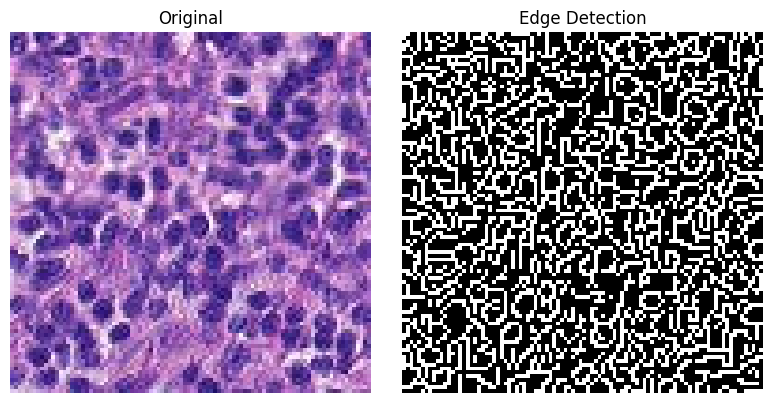

Computing channel mean/std: 100%|██████████| 1000/1000 [00:01<00:00, 859.79file/s]


Channel Means: [0.7068258  0.5499127  0.69816834]
Channel Stds: [0.17984167 0.19980958 0.16343711]


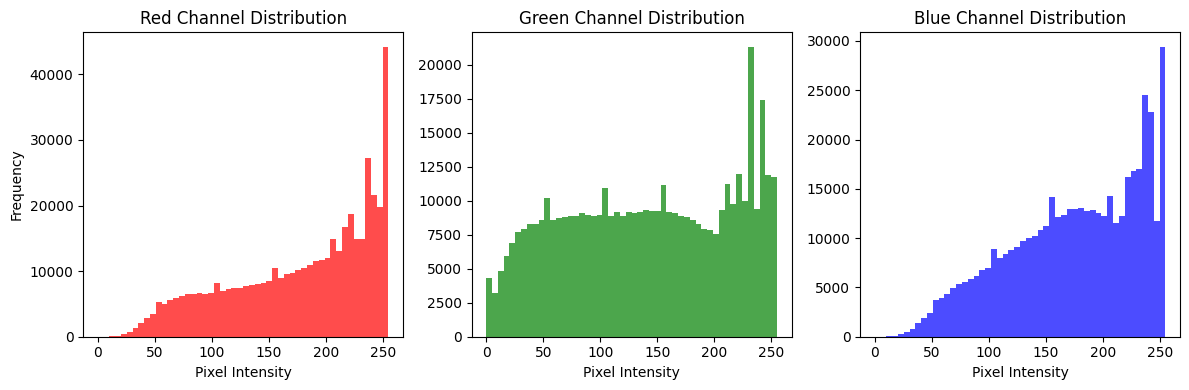

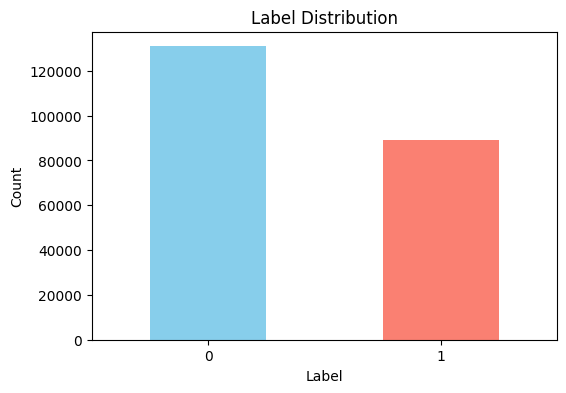

In [4]:
# EXPLORATORY DATA ANALYSIS
model_obj.sample_image_detailed()
model_obj.channel_mean_std()
model_obj.plot_pixel_histograms()
model_obj.plot_label_distribution()

# 3 -  MODEL ARCHITECTURE


### Baseline Model - SeparableConv2D

This model uses SeparableConv2D layers, which break the convolution into two parts, depthwise and pointwise. This design helps lower the number of parameters and speeds up training.

**Model Structure:**

*   Block 1: SeparableConv2D w/ 32 filters, followed by max pooling and batch normalization.
*   Block 2: SeparableConv2D w/ 64 filters, with the same pooling and normalization.
*  Block 3: SeparableConv2D w/ 128 filters, again followed by pooling and normalization.
*  Feature Aggregation: GlobalAveragePooling2D reduces the spatial data to a simple feature vector.

*    Classification Layers: A Dense layer with 64 units, a Dropout layer (rate = 0.5) to help prevent overfitting, and a final Dense layer with a sigmoid activation to make the binary prediction.


### Alternative Model - Conv2D w/ Residual Connections

This model uses regular Conv2D layers and adds residual connections, which help the network learn better by allowing some data to bypass layers. This makes it easier for the model to train deeper architectures. The structure is:

**Model Structure**



*   Initial Block: Two Conv2d layers at 32 filters each, followed by max pooling and batch normalization
*   Residual Block: Two Conv2d layer w./ 64 filters are used.
*   Deeper Block: Two more Conv2d layers w/ 128 filters to capture more detailed patterns, followed by pooling and normalization
*   Final Layers: GlobalAveragePooling2D reduces the feature maps to a vector, followed by a Dense layer with 64 units, a Dropout layer (0.5), and a final sigmoid-activated Dense layer for classification.




### Hyperparameter Tuning

I used Keras Tuner’s RandomSearch to find the best settings.

*   Number of filters: Adjusting filters in each convolution layer
*   Dense Layer Size: Between 64 and 256 unites
*   Dropout Rate: Exploring dropout values from .3 to .7 to help w/ overfitting
*   Learning Rates: .01, .001, .0001

In [5]:
print("\nTuning and Training Model:")
model_obj.tune_model(epochs=5, batch_size=32, max_trials=3)

Trial 3 Complete [00h 04m 43s]
val_accuracy: 0.742142915725708

Best val_accuracy So Far: 0.742142915725708
Total elapsed time: 00h 14m 08s
Best hyperparameters:  {'filters_1': 32, 'filters_2': 64, 'filters_3': 128, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d_3 (SeparableConv2D) │ (None, 64, 64, 32)          │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 32, 32, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 16, 16, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          24,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,308 (145.73 KB)

 Trainable params: 36,860 (143.98 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7699 - loss: 0.4935 - val_accuracy: 0.7585 - val_loss: 0.4990
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 98ms/step - accuracy: 0.8146 - loss: 0.4166 - val_accuracy: 0.6527 - val_loss: 1.0180
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 98ms/step - accuracy: 0.8288 - loss: 0.3947 - val_accuracy: 0.7148 - val_loss: 0.7542
Epoch 4/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 98ms/step - accuracy: 0.8302 - loss: 0.3781 - val_accuracy: 0.7127 - val_loss: 0.9866
Epoch 5/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 97ms/step - accuracy: 0.8372 - loss: 0.3733 - val_accuracy: 0.6444 - val_loss: 1.3023


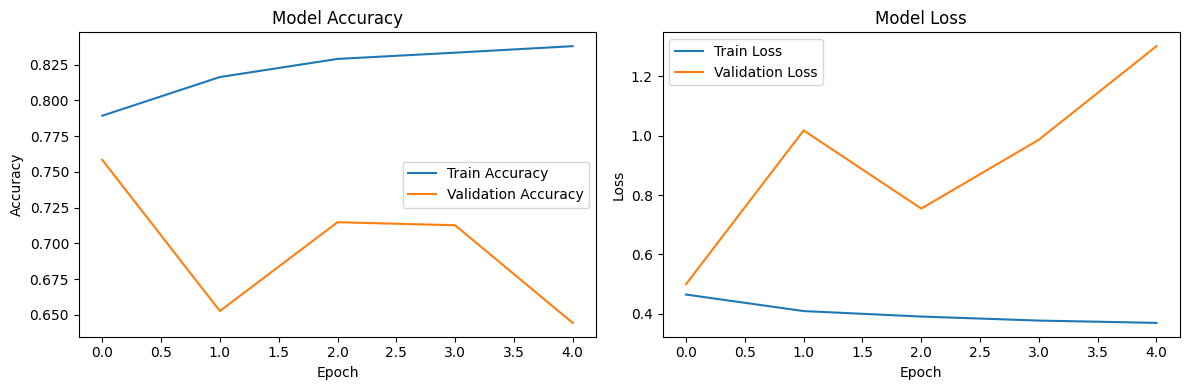

Found 44005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Validation ROC AUC: 0.7684876896129487


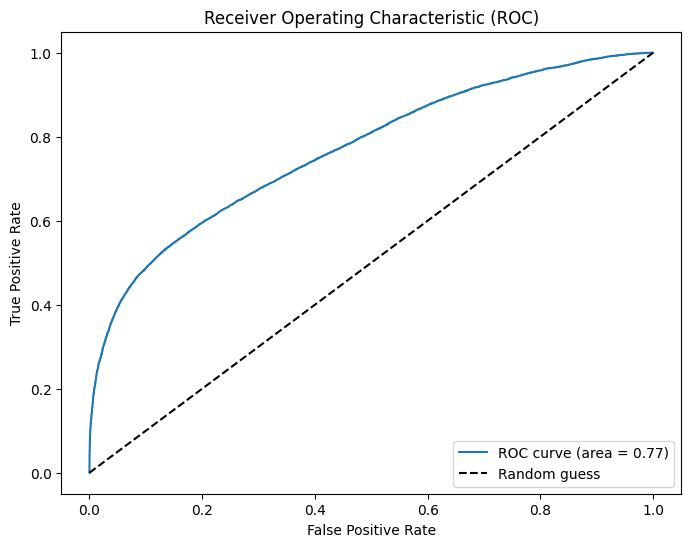

In [6]:
model_obj.plot_history()
model_obj.evaluate_auc_and_plot(batch_size=32)

In [7]:
print("\nTuning and Alternative Training Model:")
model_obj.tune_model_alternative(epochs=5, batch_size=32, max_trials=3)


Trial 3 Complete [00h 04m 51s]
val_accuracy: 0.7056925296783447

Best val_accuracy So Far: 0.7075332403182983
Total elapsed time: 00h 14m 44s
Best hyperparameters (alternative):  {'filters_1': 64, 'filters_2': 96, 'filters_3': 256, 'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.01}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ max_pooling2d_3[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 96)     │         55,392 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 96)     │         83,040 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 96)     │          6,240 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 96)     │              0 │ conv2d_10[0][0],       │
│                           │                        │                │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 96)     │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 16, 96)     │            384 │ max_pooling2d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 16, 16, 256)    │        221,440 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 256)      │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 8, 8, 256)      │          1,024 │ max_pooling2d_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 1,062,625 (4.05 MB)

 Trainable params: 1,061,793 (4.05 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.7018 - loss: 0.6499 - val_accuracy: 0.6967 - val_loss: 0.9374
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - accuracy: 0.8066 - loss: 0.4535 - val_accuracy: 0.7221 - val_loss: 0.5607
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - accuracy: 0.8162 - loss: 0.4338 - val_accuracy: 0.6293 - val_loss: 0.9830
Epoch 4/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - accuracy: 0.8196 - loss: 0.4120 - val_accuracy: 0.8029 - val_loss: 0.4147
Epoch 5/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8270 - loss: 0.4027 - val_accuracy: 0.8036 - val_loss: 0.4400


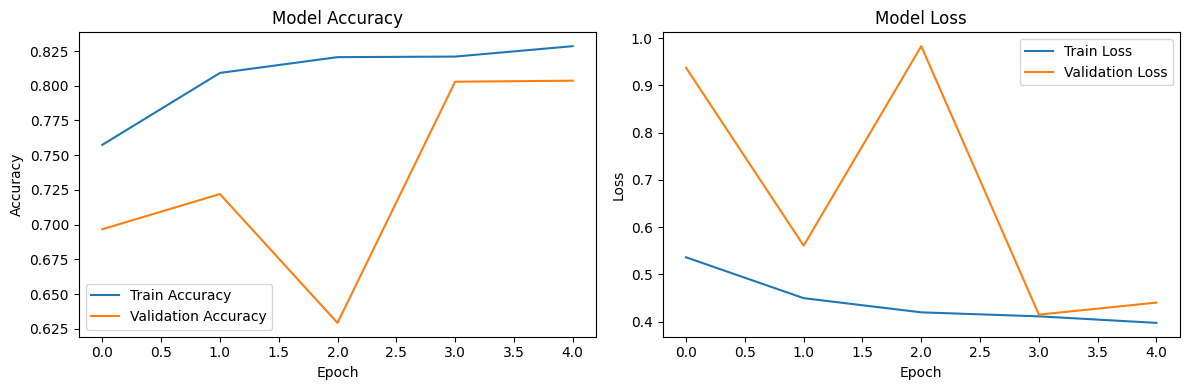

Found 44005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Validation ROC AUC: 0.9028870541396394


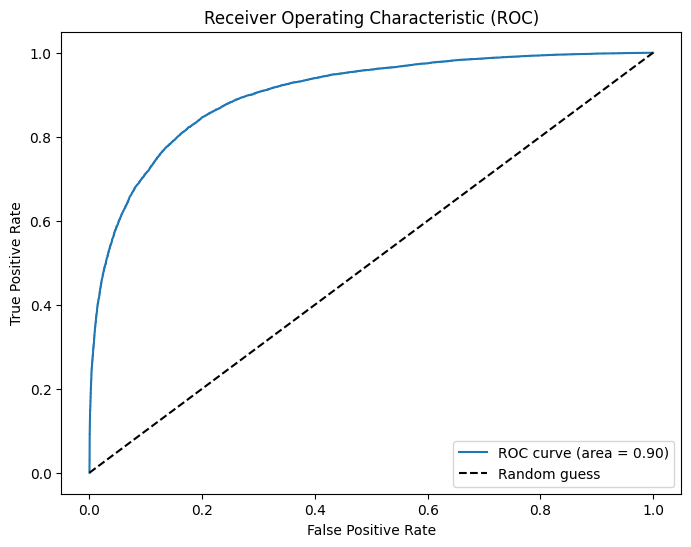

In [8]:
model_obj.plot_history()
model_obj.evaluate_auc_and_plot(batch_size=32)

# 4 - RESULTS AND ANALYSIS

After tuning and training the two models, I graphed the model accuracy and loss for the train and validation sets. I also computed and graphed the ROC score for each.

## BASE MODEL

#### Tuning
The results (best params) for the base model were outputted as:

| Hyperparameter  | Value  |
|---------------|--------|
| filters_1    | 32     |
| filters_2    | 64     |
| filters_3    | 128    |
| dense_units  | 192    |
| dropout_rate | 0.5    |
| learning_rate | 0.001  |

### Results

**Validation ROC AUC** = 0.768

As the number of epochs increased, the validation accuracy had a relative decrease while the validation loss rose. The training accuracy rose and loss decrased. This is suggestive that there is overfitting taking place because the model it was "memorizing" the training data and not generalizing.

This can be visualized clearly in the graphs above.

## ALTERNATIVE MODEL

#### Tuning
The results (best params) for the base model were outputted as:

| Hyperparameter  | Value  |
|---------------|--------|
| filters_1    | 64     |
| filters_2    | 96     |
| filters_3    | 256    |
| dense_units  | 256    |
| dropout_rate | 0.3    |
| learning_rate | 0.01   |

### Results

**Validation ROC AUC** = 0.903

The altenative model saw a dip in performance at 2 epochs, however it increased from there. By epoch 5, the validation accuracy closely tracked with the training accuracy and the validation loss dropped close to the training loss.

This can be visualized clearly in the graphs above.


# 5 - CONCLUSION

## Model Comparisons

The alternative model clearly performed better in every metric. It had a much higher ROC score (.903 vs .768), better accuracy at 5 epochs and lower loss at 5 epochs.

This model most likely performed better due to the overfitting issue of the first model, which has a relatively simple architecture.

The second model included redidual blocks which allowed for better gradient flow and enabled the network to learn deeper representations without performance loss. The hyperparameter tuning also identified different values.

## Future Work

Due to time constraints, only a portion of the dataset was trained on. This an obvious area of improvement.

Another potential improvement would be implementing transfer learning and/or ensemble methods.

In [ ]:
# OUTPUT AND RESULTS
test_folder = '/content/data/test'
output_csv = 'submission.csv'
model_obj.predict_test_set(test_folder, output_csv)